<a href="https://colab.research.google.com/github/lustraka/nd00333_AZMLND_Optimizing_a_Pipeline_in_Azure-Starter_Files/blob/master/sandbox-1/Colab_BankMarketingExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url_path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
df = pd.read_csv(url_path)
df.shape

(32950, 21)

In [4]:
def get_X_y(data, encode_cat='onehot'):
  """Prepare features and a target in line with exploratory data analysis.
  For `encode_cat` use either 'onehot' or 'label'."""
  
  df = data.copy()

  # Separate and encode the target
  y = df.pop('y').apply(lambda s: 1 if s == 'yes' else 0)

  # Binarize 'pdays' feature, as it doesn't matter how many days passed
  # due to prevalence of 'no previous contact' cases (31728)
  df['pdays'] = df['pdays'].apply(lambda i: 0 if i == 999 else 1)

  # Drop potential data leakage columns including
  # high correlated 'duration (of a call)' (coef 0.41).
  # Features related with the last contact of the current
  # campaign are not known while planning a new campaign!
  for col in ['contact', 'month', 'day_of_week', 'duration', 'campaign']:
    df.drop(col, axis=1, inplace=True)

  # Drop an uninformative column 'default'
  # which has only 3 'yes'.
  df.drop('default', axis=1, inplace=True)

  # Encode the non-numeric columns
  for col in df.select_dtypes('object').columns:
    if encode_cat == 'onehot':
      df = df.join(pd.get_dummies(df[col], prefix=col))
      df.drop(col, axis=1, inplace=True)
    else:  # Label encoding
      df[col], _ = df[col].factorize()

  # Return features and the target
  return df, y

x, y = get_X_y(df, 'onehot')
x.shape, y.shape

((32950, 41), (32950,))

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(f"Test size is {len(x_test)/len(x):.2f}.")
print(f"x_train.shape = {x_train.shape},\t x_test.shape = {x_test.shape},")
print(f"y_train.shape = {y_train.shape},\t y_test.shape = {y_test.shape}.")

Test size is 0.25.
x_train.shape = (24712, 41),	 x_test.shape = (8238, 41),
y_train.shape = (24712,),	 y_test.shape = (8238,).


# Metrics
+ [ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) in Google ML Crash Course provides a short summary with definitions and illustrations.
+ [Receiver operating charactistic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in Wikipedia gives a comprehensive explanation of the concept.
+ [3.3.2.15. Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) in SciKit Learn informs about a function `roc_curve` and gives a small example.

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_clf(x_train, y_train, x_test, y_test, clf):
  """Evaluate a clasifier and return ROC axes and AUC."""

  clf.fit(x_train, y_train)
  y_score = clf.predict(x_test)
  fpr, tpr, tresholds = roc_curve(y_test, y_score)
  auc = roc_auc_score(y_test, y_score)
  name = str(type(clf)).split('.')[-1].replace("'>",'')

  return fpr, tpr, auc, name

In [17]:
def plot_roc_curve(fpr, tpr, auc, name):
  """Plot ROC curve. Print AUC score."""

  plt.figure()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
  plt.legend()
  plt.title('ROC curve of ' + name)
  plt.show()

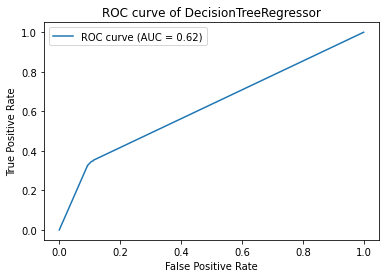

In [18]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
plot_roc_curve(*evaluate_clf(x_train, y_train, x_test, y_test, clf))

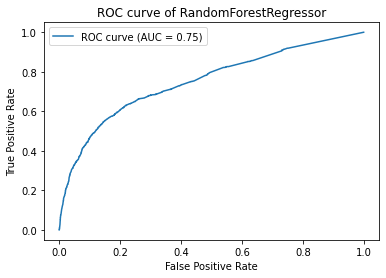

In [19]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
plot_roc_curve(*evaluate_clf(x_train, y_train, x_test, y_test, clf))

In [31]:
import requests
import ast
urls = {
    'HyperDrive' : 'https://raw.githubusercontent.com/lustraka/nd00333_AZMLND_Optimizing_a_Pipeline_in_Azure-Starter_Files/master/sandbox-1/best_hdr_run_metrics.txt',
    'AutoML' : 'https://raw.githubusercontent.com/lustraka/nd00333_AZMLND_Optimizing_a_Pipeline_in_Azure-Starter_Files/master/sandbox-1/best_aml_run_metrics.txt'
}

In [39]:
metrics = {k:ast.literal_eval(requests.get(v).text) for k,v in urls.items()}

In [36]:
urls_details = {
    'HyperDrive' : 'https://raw.githubusercontent.com/lustraka/nd00333_AZMLND_Optimizing_a_Pipeline_in_Azure-Starter_Files/master/sandbox-1/best_hdr_run_details.txt',
    'AutoML' : 'https://raw.githubusercontent.com/lustraka/nd00333_AZMLND_Optimizing_a_Pipeline_in_Azure-Starter_Files/master/sandbox-1/best_aml_run_details.txt'
}
details = {k:ast.literal_eval(requests.get(v).text) for k,v in urls_details.items()}

In [43]:
C = metrics['HyperDrive']['Regularization Strength:']
max_iter = metrics['HyperDrive']['Max iterations:']
C, max_iter

(47.00488472299381, 1000)

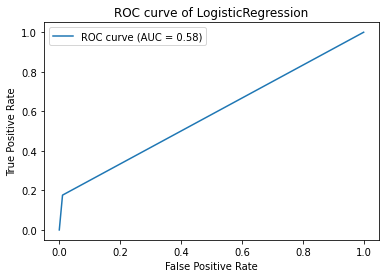

In [52]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=C, max_iter=max_iter)
fpr, tpr, auc, name = evaluate_clf(x_train, y_train, x_test, y_test, clf)
metrics['HyperDrive']['AUC'] = auc
plot_roc_curve(fpr, tpr, auc, name)

In [45]:
clf.get_params()

{'C': 47.00488472299381,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


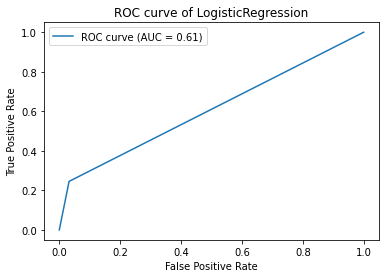

In [46]:
clf = LogisticRegression()
plot_roc_curve(*evaluate_clf(x_train, y_train, x_test, y_test, clf))

In [47]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [62]:
pd.DataFrame({
    'Accuracy' : [metrics['HyperDrive']['Accuracy'], metrics['AutoML']['accuracy']],
    'AUC' : [metrics['HyperDrive']['AUC'], metrics['AutoML']['AUC_weighted']]
}, index=['HyperDrive', 'AutoML'])

,Accuracy,AUC
HyperDrive,0.898276,0.582695
AutoML,0.739162,0.797378


In [55]:
aml_details = details['AutoML']

In [56]:
import re
[x for x in [aml_details['properties']['ensemble_weights'],aml_details['properties']['ensembled_algorithms']]]

['[0.35714285714285715, 0.14285714285714285, 0.07142857142857142, 0.07142857142857142, 0.07142857142857142, 0.07142857142857142, 0.21428571428571427]',
 "['XGBoostClassifier', 'LightGBM', 'XGBoostClassifier', 'LightGBM', 'XGBoostClassifier', 'XGBoostClassifier', 'RandomForest']"]

In [57]:
ensembled_algorithms = re.findall(r'\'(.*?)\'', aml_details['properties']['ensembled_algorithms'])
tmp = [re.findall(r'(0.*)[,\]]', n) for n in aml_details['properties']['ensemble_weights'].split()]
ensemble_weights = [float(n[0]) for n in tmp]

In [58]:
[len(x) for x in [ensemble_weights, ensembled_algorithms]]

[7, 7]

In [59]:
pd.DataFrame({'ensembled_algorithms': ensembled_algorithms, 'ensemble_weights': ensemble_weights}).sort_values(by='ensemble_weights', ascending=False)

,ensembled_algorithms,ensemble_weights
0,XGBoostClassifier,0.357143
6,RandomForest,0.214286
1,LightGBM,0.142857
2,XGBoostClassifier,0.071429
3,LightGBM,0.071429
4,XGBoostClassifier,0.071429
5,XGBoostClassifier,0.071429


In [63]:
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier

In [64]:
clfs = [[LogisticRegression(C=C, max_iter=max_iter), XGBRegressor()], [RandomForestRegressor(), LGBMClassifier()]]

[07:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


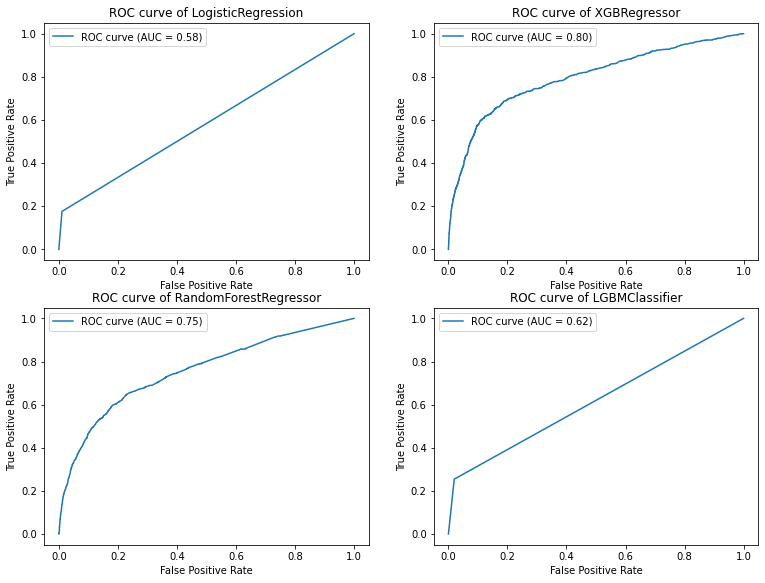

In [73]:
def plot_roc_curves(fpr, tpr, auc, name, ax):
  """Plot ROC curve. Print AUC score."""
  
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
  ax.legend()
  ax.set_title('ROC curve of ' + name)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(6.4*2, 4.8*2)
for i in range(2):
  for j in range(2):
    ax[i][j] = plot_roc_curves(*evaluate_clf(x_train, y_train, x_test, y_test, clfs[i][j]), ax[i][j])
plt.show()